## Work
1. 請嘗試寫一個 callback 用來記錄各類別在訓練過程中，對驗證集的 True Positive 與 True Negative

In [17]:
# 從網路即時下載CIFAR10⼩圖像，數據集涵蓋50,000張32x32彩⾊色訓練圖像及10,000張測試圖像，並且標註超過10個類別
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# 查詢檔案維度資訊
print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of x_test: {x_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of x_train: (50000, 32, 32, 3)
Shape of y_train: (50000, 1)
Shape of x_test: (10000, 32, 32, 3)
Shape of y_test: (10000, 1)


In [0]:
# 資料前處理
def preproc_x(x):
    x = x.reshape((len(x), -1)) / 255.
    return x

def preproc_y(y, num_classes=10):
    from keras.utils import to_categorical

    y = to_categorical(y, num_classes)
    return y    

In [19]:
# 將資料從圖形 (RGB) 轉為向量 (Single Vector) 並進行標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)
print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of x_test: {x_test.shape}")


# 將目標轉為 one-hot encoding
y_train = preproc_y(y_train, num_classes=10)
y_test = preproc_y(y_test, num_classes=10)
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of x_train: (50000, 3072)
Shape of x_test: (10000, 3072)
Shape of y_train: (50000, 10)
Shape of y_test: (10000, 10)


In [0]:
from keras.layers import BatchNormalization
from keras import layers, models

def build_model(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    model = models.Sequential()
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            # 第一層
            model.add(layers.Dense(n_units, activation='relu', input_shape=(input_shape)))
            model.add(BatchNormalization())
        else:
            # 後續幾層
            model.add(layers.Dense(n_units, activation='relu'))
            model.add(BatchNormalization())

    # 最後一層
    model.add(layers.Dense(output_units, activation='softmax'))
    return model

In [0]:
# 超參數設定
learning_rate = 1e-3
epochs = 50
batch_size = 256
momentum = 0.95

In [0]:
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix
import numpy as np

class Record_tp_tn(Callback):
    def on_train_begin(self, epoch, logs={}):
        logs = logs or {}
        record_items = ["val_tp", "val_tn", "val_fp", "val_fn"]
        for i in record_items:
            if i not in self.params['metrics']:
                self.params['metrics'].append(i)
    
    def on_epoch_end(self, epoch, logs={}):
        logs = logs or {}
        y_true = self.validation_data[1].argmax(axis=1)     # validation_data=(x_test, y_test), so validation_data[1]=y_test
        y_pred = self.model.predict(self.validation_data[0])
        y_pred = y_pred.argmax(axis=1)

        CM = confusion_matrix(y_true, y_pred)
        FP = CM.sum(axis=0) - np.diag(CM)
        FN = CM.sum(axis=1) - np.diag(CM)
        TP = np.diag(CM)
        TN = CM.sum() - (FP + FN + TP)

        logs["val_tp"] = sum(TP)
        logs["val_tn"] = sum(TN)
        logs["val_fp"] = sum(FP)
        logs["val_fn"] = sum(FN)
        
rec_tptn = Record_tp_tn()

In [23]:
import keras
keras.backend.clear_session()

model = build_model(input_shape=x_train.shape[1:], output_units=10, num_neurons=[512, 256, 128])
print(model.summary())

model.compile(optimizer=keras.optimizers.SGD(lr=learning_rate, nesterov=True, momentum=momentum),
              loss="categorical_crossentropy", 
              metrics=["accuracy"])

history = model.fit(x_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    validation_data=(x_test, y_test), 
                    shuffle=True,
                    callbacks=[rec_tptn])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
_________________________________________________________________
dense_4 (Dense)              (None, 10)               

In [24]:
print(model.history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'val_tp', 'val_tn', 'val_fp', 'val_fn'])


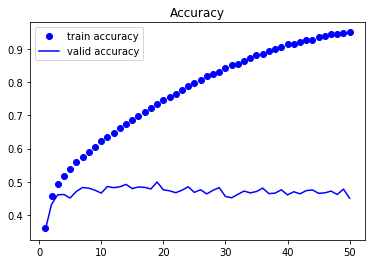

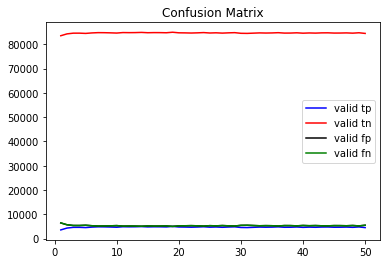

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(1, epochs+1), model.history.history['acc'], 'bo', label="train accuracy")
plt.plot(range(1, epochs+1), model.history.history['val_acc'], 'b-', label="valid accuracy")
plt.legend()
plt.title("Accuracy")

plt.figure()
plt.plot(range(1, epochs+1), model.history.history['val_tp'], label="valid tp", color="b")
plt.plot(range(1, epochs+1), model.history.history['val_tn'], label="valid tn", color="r")
plt.plot(range(1, epochs+1), model.history.history['val_fp'], label="valid fp", color="k")
plt.plot(range(1, epochs+1), model.history.history['val_fn'], label="valid fn", color="g")
plt.legend()
plt.title("Confusion Matrix");